# Data Preprocessing

In this notebook, I calibrate the Ariel data and visualize a calibrated image, along with the original image for comparison. The calibration code is from the [Calibrating and Binning Ariel Data](https://www.kaggle.com/code/gordonyip/calibrating-and-binning-ariel-data) notebook by Gordon Yip. There are 7 steps:
1. Analog-to-Digital Conversion (ADC)
2. Mask Hot/Dead Pixels
3. Linearity Correction
4. Dark Current Subtraction
5. Get Correlated Double Sampling (CDS)
6. (Optional) Time Binning
7. Flat Field Correction

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import itertools
import os
import glob 
import seaborn as sns
from astropy.stats import sigma_clip
from tqdm import tqdm

sns.set_theme(style='darkgrid')
palette = sns.color_palette('muted')

In [2]:
path_folder = '/kaggle/input/ariel-data-challenge-2025/' 
path_out = '/kaggle/tmp/data_light_raw/'

if not os.path.exists(path_out):
    os.makedirs(path_out)
    print(f"Directory {path_out} created.")
else:
    print(f"Directory {path_out} already exists.")

CHUNKS_SIZE = 1

Directory /kaggle/tmp/data_light_raw/ created.


## Functions

In [3]:
def ADC_convert(signal, gain=0.4369, offset=-1000):
    """The Analog-to-Digital Conversion (adc) is performed by the detector to convert
    the pixel voltage into an integer number. Since we are using the same conversion number 
    this year, we have simply hard-coded it inside."""
    signal = signal.astype(np.float64)
    signal /= gain
    signal += offset
    return signal

def mask_hot_dead(signal, dead, dark):
    hot = sigma_clip(
        dark, sigma=5, maxiters=5
    ).mask
    hot = np.tile(hot, (signal.shape[0], 1, 1))
    dead = np.tile(dead, (signal.shape[0], 1, 1))
    signal = np.ma.masked_where(dead, signal)
    signal = np.ma.masked_where(hot, signal)
    return signal

def apply_linear_corr(linear_corr, clean_signal):
    linear_corr = np.flip(linear_corr, axis=0)
    for x, y in itertools.product(
                range(clean_signal.shape[1]), range(clean_signal.shape[2])
            ):
        poli = np.poly1d(linear_corr[:, x, y])
        clean_signal[:, x, y] = poli(clean_signal[:, x, y])
    return clean_signal

def clean_dark(signal, dead, dark, dt):
    dark = np.ma.masked_where(dead, dark)
    dark = np.tile(dark, (signal.shape[0], 1, 1))
    signal -= dark * dt[:, np.newaxis, np.newaxis]
    return signal

def get_cds(signal):
    cds = signal[:,1::2,:,:] - signal[:,::2,:,:]
    return cds

def bin_obs(cds_signal, binning):
    cds_transposed = cds_signal.transpose(0,1,3,2)
    cds_binned = np.zeros((cds_transposed.shape[0], cds_transposed.shape[1] // binning, cds_transposed.shape[2], cds_transposed.shape[3]))
    for i in range(cds_transposed.shape[1] // binning):
        cds_binned[:,i,:,:] = np.sum(cds_transposed[:,i*binning:(i+1)*binning,:,:], axis=1)
    return cds_binned

def correct_flat_field(flat, dead, signal):
    flat = flat.transpose(1, 0)
    dead = dead.transpose(1, 0)
    flat = np.ma.masked_where(dead, flat)
    flat = np.tile(flat, (signal.shape[0], 1, 1))
    signal /= flat
    return signal

def get_index(files, CHUNKS_SIZE):
    index = []
    for file in files:
        file_name = file.split('/')[-1]
        if file_name.split('_')[0] == 'AIRS-CH0' and file_name.split('_')[1] == 'signal' and file_name.split('_')[2] == '0.parquet':
            file_index = os.path.basename(os.path.dirname(file))
            index.append(int(file_index))
    index = np.array(index)
    index = np.sort(index) 
    # credit to DennisSakva
    index = np.array_split(index, len(index) // CHUNKS_SIZE)
    
    return index

## Calibration

In [4]:
# Select a random planet_id
df_train_star_info = pd.read_csv(path_folder + 'train_star_info.csv')
planet_id = df_train_star_info['planet_id'].sample(n=1, random_state=42).iloc[0]
print('planet_id:', planet_id)

planet_id: 1266154112


In [5]:
# List all paths in train for the specified planet_id
files = glob.glob(os.path.join(path_folder + 'train/' + str(planet_id), '*'))
print(len(files))
files

4


['/kaggle/input/ariel-data-challenge-2025/train/1266154112/FGS1_signal_0.parquet',
 '/kaggle/input/ariel-data-challenge-2025/train/1266154112/AIRS-CH0_calibration_0',
 '/kaggle/input/ariel-data-challenge-2025/train/1266154112/FGS1_calibration_0',
 '/kaggle/input/ariel-data-challenge-2025/train/1266154112/AIRS-CH0_signal_0.parquet']

In [6]:
index = get_index(files, CHUNKS_SIZE)  
print(len(index))
index

1


[array([1266154112])]

In [7]:
axis_info = pd.read_parquet(os.path.join(path_folder, 'axis_info.parquet'))

DO_MASK = True
DO_THE_NL_CORR = False
DO_DARK = True
DO_FLAT = True
TIME_BINNING = True

cut_inf, cut_sup = 39, 321
l = cut_sup - cut_inf

In [8]:
for n, index_chunk in enumerate(tqdm(index)):
    AIRS_CH0_clean = np.zeros((CHUNKS_SIZE, 11250, 32, l))
    FGS1_clean = np.zeros((CHUNKS_SIZE, 135000, 32, 32))
    
    for i in range(CHUNKS_SIZE): 
        # AIRS Data
        df = pd.read_parquet(os.path.join(path_folder, f'train/{index_chunk[i]}/AIRS-CH0_signal_0.parquet'))
        signal = df.values.astype(np.float64).reshape((df.shape[0], 32, 356))

        # 1. ADC Conversion
        signal = ADC_convert(signal,)
        dt_airs = axis_info['AIRS-CH0-integration_time'].dropna().values
        dt_airs[1::2] += 0.1
        chopped_signal = signal[:, :, cut_inf:cut_sup]
        del signal, df
        
        # CLEANING THE DATA: AIRS
        flat = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/AIRS-CH0_calibration_0/flat.parquet')).values.astype(np.float64).reshape((32, 356))[:, cut_inf:cut_sup]
        dark = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/AIRS-CH0_calibration_0/dark.parquet')).values.astype(np.float64).reshape((32, 356))[:, cut_inf:cut_sup]
        dead_airs = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/AIRS-CH0_calibration_0/dead.parquet')).values.astype(np.float64).reshape((32, 356))[:, cut_inf:cut_sup]
        linear_corr = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/AIRS-CH0_calibration_0/linear_corr.parquet')).values.astype(np.float64).reshape((6, 32, 356))[:, :, cut_inf:cut_sup]

        # 2. Mask Hot/Dead Pixels
        if DO_MASK:
            chopped_signal = mask_hot_dead(chopped_signal, dead_airs, dark)
        AIRS_CH0_clean[i] = chopped_signal

        # 3. Linearity Correction
        if DO_THE_NL_CORR: 
            linear_corr_signal = apply_linear_corr(linear_corr, AIRS_CH0_clean[i])
            AIRS_CH0_clean[i,:, :, :] = linear_corr_signal
        del linear_corr

        # 4. Dark Current Subtraction
        if DO_DARK: 
            cleaned_signal = clean_dark(AIRS_CH0_clean[i], dead_airs, dark, dt_airs)
            AIRS_CH0_clean[i] = cleaned_signal
        else: 
            pass
        del dark

        # FGS1
        df = pd.read_parquet(os.path.join(path_folder, f'train/{index_chunk[i]}/FGS1_signal_0.parquet'))
        fgs_signal = df.values.astype(np.float64).reshape((df.shape[0], 32, 32))

        # 1. ADC Conversion
        fgs_signal = ADC_convert(fgs_signal,)
        dt_fgs1 = np.ones(len(fgs_signal)) * 0.1
        dt_fgs1[1::2] += 0.1
        chopped_FGS1 = fgs_signal
        del fgs_signal, df
        
        # CLEANING THE DATA: FGS1
        flat = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/FGS1_calibration_0/flat.parquet')).values.astype(np.float64).reshape((32, 32))
        dark = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/FGS1_calibration_0/dark.parquet')).values.astype(np.float64).reshape((32, 32))
        dead_fgs1 = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/FGS1_calibration_0/dead.parquet')).values.astype(np.float64).reshape((32, 32))
        linear_corr = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/FGS1_calibration_0/linear_corr.parquet')).values.astype(np.float64).reshape((6, 32, 32))

        # 2. Mask Hot/Dead pixels
        if DO_MASK:
            chopped_FGS1 = mask_hot_dead(chopped_FGS1, dead_fgs1, dark)
        FGS1_clean[i] = chopped_FGS1

        # 3. Linearity Correction
        if DO_THE_NL_CORR: 
            linear_corr_signal = apply_linear_corr(linear_corr, FGS1_clean[i])
            FGS1_clean[i,:, :, :] = linear_corr_signal
        del linear_corr

        # 4. Dark Current Subtraction
        if DO_DARK: 
            cleaned_signal = clean_dark(FGS1_clean[i], dead_fgs1, dark,dt_fgs1)
            FGS1_clean[i] = cleaned_signal
        else: 
            pass
        del dark
        
    # SAVE DATA AND FREE SPACE
    # 5. Get Correlated Double Sampling
    AIRS_cds = get_cds(AIRS_CH0_clean)
    FGS1_cds = get_cds(FGS1_clean)
    
    del AIRS_CH0_clean, FGS1_clean
    
    # 6. (Optional) Time Binning (to reduce space)
    if TIME_BINNING:
        AIRS_cds_binned = bin_obs(AIRS_cds,binning=30)
        FGS1_cds_binned = bin_obs(FGS1_cds,binning=30*12)
    else:
        AIRS_cds = AIRS_cds.transpose(0,1,3,2) ## this is important to make it consistent for flat fielding, but you can always change it
        AIRS_cds_binned = AIRS_cds
        FGS1_cds = FGS1_cds.transpose(0,1,3,2)
        FGS1_cds_binned = FGS1_cds
    
    del AIRS_cds, FGS1_cds

    # 7. Flat Field Correction
    for i in range(CHUNKS_SIZE):
        if DO_FLAT:
            flat_airs = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/AIRS-CH0_calibration_0/flat.parquet')).values.astype(np.float64).reshape((32, 356))[:, cut_inf:cut_sup]
            flat_fgs = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/FGS1_calibration_0/flat.parquet')).values.astype(np.float64).reshape((32, 32))
            corrected_AIRS_cds_binned = correct_flat_field(flat_airs,dead_airs, AIRS_cds_binned[i])
            AIRS_cds_binned[i] = corrected_AIRS_cds_binned
            corrected_FGS1_cds_binned = correct_flat_field(flat_fgs,dead_fgs1, FGS1_cds_binned[i])
            FGS1_cds_binned[i] = corrected_FGS1_cds_binned
        else:
            pass

    # Save data
    np.save(os.path.join(path_out, 'AIRS_clean_train_{}.npy'.format(n)), AIRS_cds_binned)
    np.save(os.path.join(path_out, 'FGS1_train_{}.npy'.format(n)), FGS1_cds_binned)
    del AIRS_cds_binned
    del FGS1_cds_binned

100%|██████████| 1/1 [00:15<00:00, 15.62s/it]


In [9]:
def load_data(file, chunk_size, nb_files): 
    data0 = np.load(file + '_0.npy')
    data_all = np.zeros((nb_files * chunk_size, data0.shape[1], data0.shape[2], data0.shape[3]))
    data_all[:chunk_size] = data0
    for i in range(1, nb_files): 
        data_all[i * chunk_size : (i+1) * chunk_size] = np.load(file + '_{}.npy'.format(i))
    return data_all 

data_train_AIRS = load_data(path_out + 'AIRS_clean_train', CHUNKS_SIZE, len(index)) 
data_train_FGS = load_data(path_out + 'FGS1_train', CHUNKS_SIZE, len(index))

In [10]:
print('Shape of the training datasets: \t')
print('\n For AIRS-CH0:', data_train_AIRS.shape)
print('\n For FGS1:', data_train_FGS.shape)

Shape of the training datasets: 	

 For AIRS-CH0: (1, 187, 282, 32)

 For FGS1: (1, 187, 32, 32)


## Visualization

### Original Image

In [11]:
# Load the FGS1 signal data
path_train = path_folder + 'train/' + str(planet_id) + '/'
df_fgs1_signal = pd.read_parquet(path_train + 'FGS1_signal_0.parquet')

print(df_fgs1_signal.shape)
print(df_fgs1_signal.iloc[i].shape)

(135000, 1024)
(1024,)


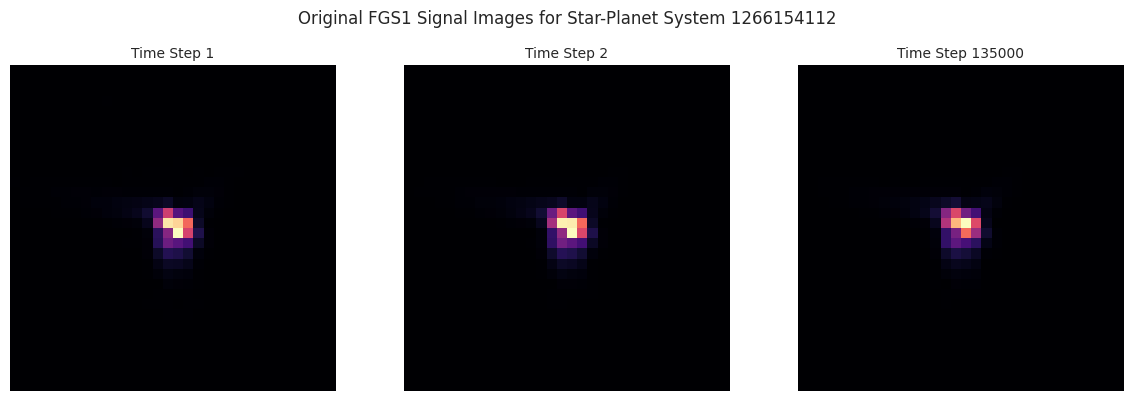

In [12]:
# Visualize 3 time steps of the randomly selected planet_id from FGS1
colormap = 'magma'
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# 3 time steps: 1st, 2nd, last
time_steps = [0, 1, len(df_fgs1_signal) - 1]
images = [np.reshape(df_fgs1_signal.iloc[i], (32, 32)) for i in time_steps]

i = 0
for ax, img in zip(axes, images):
    ax.imshow(img, cmap=colormap)
    ax.set_title(f'Time Step {time_steps[i] + 1}', fontsize=10)
    i += 1
    ax.axis('off')

fig.suptitle('Original FGS1 Signal Images for Star-Planet System ' + str(planet_id), y=1, fontsize=12)

plt.tight_layout()
plt.show()

### Calibrated Image

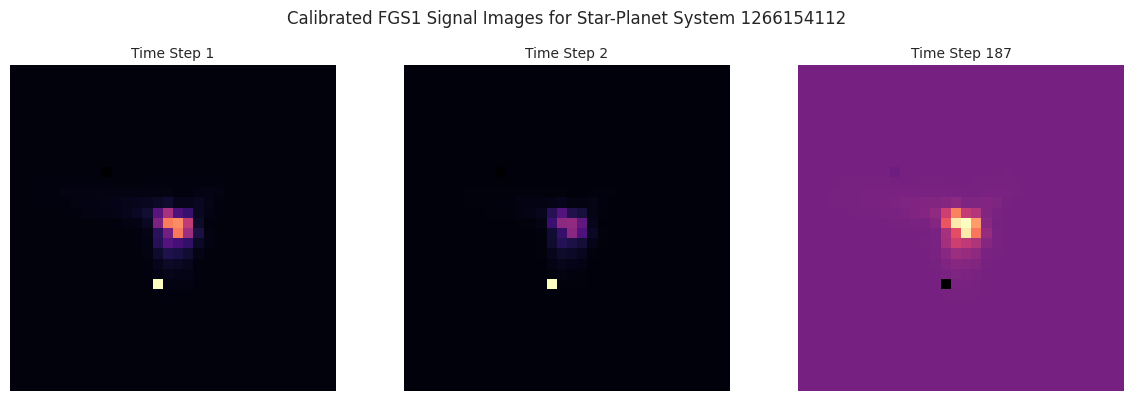

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# 3 time steps: 1st, 2nd, last
time_steps = [0, 1, data_train_FGS.shape[1] - 1]
images = [np.reshape(data_train_FGS[0,i,:,:], (32, 32)) for i in time_steps]

i = 0
for ax, img in zip(axes, images):
    ax.imshow(img.T, cmap=colormap)
    ax.set_title(f'Time Step {time_steps[i] + 1}', fontsize=10)
    i += 1
    ax.axis('off')

fig.suptitle('Calibrated FGS1 Signal Images for Star-Planet System ' + str(planet_id), y=1, fontsize=12)

plt.tight_layout()
plt.show()

### Light Curve

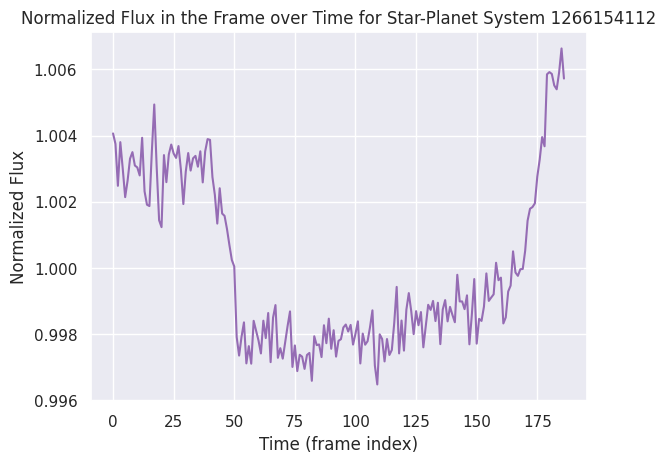

In [14]:
for i in range(len(data_train_AIRS)) : 
    light_curve = data_train_AIRS[i,:,:,:].sum(axis=(1,2))
    plt.plot(light_curve / light_curve.mean(), '-', alpha=1.0, color=palette[4])

plt.title('Normalized Flux in the Frame over Time for Star-Planet System ' + str(planet_id))
plt.xlabel('Time (frame index)')
plt.ylabel('Normalized Flux')
plt.show()